In [1]:
import os
import time
import tracemalloc
from glob import glob

import xarray as xr
import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spatialproteomics as sp
from tqdm.auto import tqdm
import gc

# this is just for testing
num_samples = 40

channel_options_numeric = [1, 5, 10, 20, 30, 40, 50, 56]
channels = list(pd.read_csv('/g/huber/projects/CITEseq/CODEX/BNHL_TMA/MarkerList.txt', header=None)[0])
channel_options_string = [channels[:x] if x is not None else channels for x in channel_options_numeric]
results = []

def benchmark_read_tiff(path, channels=None, spatial_subset=None):
    """Read full TIFF first, then subset in memory (channels and/or spatial)."""
    tracemalloc.start()
    start = time.perf_counter()

    # reading
    img = tifffile.imread(path)

    # subsetting
    if channels is not None:
        if spatial_subset is None:
            img = img[:channels, ...]
        else:
            img = img[:channels, 0:spatial_subset, 0:spatial_subset]
    elif spatial_subset is not None:
        img = img[:, 0:spatial_subset, 0:spatial_subset]

    end = time.perf_counter()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return end - start, peak / 1e6

def benchmark_read_zarr(path, channels=None, spatial_subset=None, trigger_read=True):
    """Read Zarr file with optional channel + spatial subsetting."""
    tracemalloc.start()
    start = time.perf_counter()

    # read file
    ds = xr.open_zarr(path)
    
    # subset file
    if channels is not None:
        if spatial_subset is None:
            ds = ds.pp[channels]
        else:
            ds = ds.pp[channels, 0:spatial_subset, 0:spatial_subset]
    elif spatial_subset is not None:
        ds = ds.pp[0:spatial_subset, 0:spatial_subset]
        
    if trigger_read:
        ds = ds["_image"].values  # trigger actual read

    end = time.perf_counter()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return end - start, peak / 1e6  # runtime (s), memory (MB)

In [2]:
print(channel_options_numeric)
print(channel_options_string)

[1, 5, 10, 20, 30, 40, 50, 56]
[['DAPI'], ['DAPI', 'Helios', 'CD10', 'TCF7/TCF1', 'PD-L1'], ['DAPI', 'Helios', 'CD10', 'TCF7/TCF1', 'PD-L1', 'BCL-6', 'FOXP3', 'CD69', 'Perforin', 'CD19'], ['DAPI', 'Helios', 'CD10', 'TCF7/TCF1', 'PD-L1', 'BCL-6', 'FOXP3', 'CD69', 'Perforin', 'CD19', 'LAG3', 'CD21', 'CD62L', 'c-myc', 'CD138', 'CD15', 'BCL-2', 'CD56', 'IKZF3', 'CD25'], ['DAPI', 'Helios', 'CD10', 'TCF7/TCF1', 'PD-L1', 'BCL-6', 'FOXP3', 'CD69', 'Perforin', 'CD19', 'LAG3', 'CD21', 'CD62L', 'c-myc', 'CD138', 'CD15', 'BCL-2', 'CD56', 'IKZF3', 'CD25', 'NOXA', 'Tim3', 'Serpin B9', 'Podoplanin', 'CD38', 'SPARC', 'ICOS', 'CXCR5', 'CD163', 'FADD'], ['DAPI', 'Helios', 'CD10', 'TCF7/TCF1', 'PD-L1', 'BCL-6', 'FOXP3', 'CD69', 'Perforin', 'CD19', 'LAG3', 'CD21', 'CD62L', 'c-myc', 'CD138', 'CD15', 'BCL-2', 'CD56', 'IKZF3', 'CD25', 'NOXA', 'Tim3', 'Serpin B9', 'Podoplanin', 'CD38', 'SPARC', 'ICOS', 'CXCR5', 'CD163', 'FADD', 'p53', 'Collagen IV', 'CD4', 'CD7', 'Kappa', 'CD20', 'CD34', 'PAX5', 'PD-1', 'CD45

In [3]:
# TIFF full-then-subset
for tiff_file in tqdm(glob(os.path.join("selected_tiffs", "*.tiff"))[:num_samples]):  # always read full TIFFs
    for ch in tqdm(channel_options_numeric):
        for subset in ["full", 500, 1000, 2000]:
            spatial = None if subset == "full" else subset
            runtime, mem = benchmark_read_tiff(tiff_file, channels=ch, spatial_subset=spatial)
            results.append({
                "format": "tiff",
                "method": "full_then_subset",
                "subset": subset if subset != "full" else 3000,
                "channels": ch if ch is not None else "all",
                "runtime_s": runtime,
                "memory_mb": mem,
            })
            gc.collect()

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fffe7186e30>>
Traceback (most recent call last):
  File "/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fffe7186e30>>
Traceback (most recent call last):
  File "/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for zarr_file in tqdm(glob(os.path.join("selected_zarrs", "*.zarr"))[:num_samples]):
    for ch in tqdm(channel_options_string):
        for subset in ["full", 500, 1000, 2000]:
            spatial = None if subset == "full" else subset
            runtime, mem = benchmark_read_zarr(zarr_file, channels=ch, spatial_subset=spatial)
            results.append({
                "format": "zarr_compute",
                "method": "compute",
                "subset": subset if subset != "full" else 3000,
                "channels": len(ch) if ch is not None else "all",
                "runtime_s": runtime,
                "memory_mb": mem,
            })
            gc.collect()

In [ ]:
for zarr_file in tqdm(glob(os.path.join("selected_zarrs", "*.zarr"))[:num_samples]):
    for ch in tqdm(channel_options_string):
        for subset in ["full", 500, 1000, 2000]:
            spatial = None if subset == "full" else subset
            runtime, mem = benchmark_read_zarr(zarr_file, channels=ch, spatial_subset=spatial, trigger_read=False)
            results.append({
                "format": "zarr_lazy",
                "method": "lazy",
                "subset": subset if subset != "full" else 3000,
                "channels": len(ch) if ch is not None else "all",
                "runtime_s": runtime,
                "memory_mb": mem,
            })
            gc.collect()

In [ ]:
# --- Results DataFrame ---
df = pd.DataFrame(results)
df

In [ ]:
df.to_csv("results/file_reading/benchmark_results.csv", index=False)

In [ ]:
df_tmp = df[df['subset'] == 3000]
plt.figure(figsize=(10, 6))
sns.lineplot(df_tmp, x='channels', y='runtime_s', hue='format')
# plt.yscale('log')

In [ ]:
df_tmp = df[df['subset'] == 3000]
plt.figure(figsize=(10, 6))
sns.lineplot(df_tmp, x='channels', y='memory_mb', hue='format')
plt.yscale('log')

In [ ]:
df_tmp = df[df['channels'] == 56]
plt.figure(figsize=(10, 6))
sns.lineplot(df_tmp, x='subset', y='runtime_s', hue='format')
# plt.yscale('log')

In [ ]:
df_tmp = df[df['channels'] == 56]
plt.figure(figsize=(10, 6))
sns.lineplot(df_tmp, x='subset', y='memory_mb', hue='format')
plt.title("Peak Memory")
plt.yscale('log')

# Standalone experiments

In [ ]:
import time
import tracemalloc
import xarray as xr
import tifffile
import spatialproteomics as sp

In [ ]:
# start memory tracking
tracemalloc.start()

start_time = time.perf_counter()
ds = xr.open_zarr('selected_zarrs/DLBCL_1_1.zarr/')
end_time = time.perf_counter()

# get peak memory usage
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Time to open zarr: {end_time - start_time:.4f} s")
print(f"Peak memory: {peak / 1e6:.2f} MB")

In [ ]:
# start memory tracking
tracemalloc.start()

start_time = time.perf_counter()
ds = tifffile.imread('selected_tiffs/DLBCL_1_1.tiff')
end_time = time.perf_counter()

# get peak memory usage
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Time to open zarr: {end_time - start_time:.4f} s")
print(f"Peak memory: {peak / 1e6:.2f} MB")

In [ ]:
# start memory tracking
tracemalloc.start()

start_time = time.perf_counter()
ds = xr.open_zarr('selected_zarrs/DLBCL_1_1.zarr/')
ds = ds['_image']

end_time = time.perf_counter()

# get peak memory usage
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Time to open zarr: {end_time - start_time:.4f} s")
print(f"Peak memory: {peak / 1e6:.2f} MB")

In [ ]:
# start memory tracking
tracemalloc.start()

start_time = time.perf_counter()
ds = xr.open_zarr('selected_zarrs/DLBCL_1_1.zarr/')
ds = ds['_image'].values

end_time = time.perf_counter()

# get peak memory usage
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Time to open zarr: {end_time - start_time:.4f} s")
print(f"Peak memory: {peak / 1e6:.2f} MB")

In [ ]:
ds = xr.open_zarr('selected_zarrs/DLBCL_1_1.zarr/')
ds['_image']

In [ ]:
tracemalloc.start()
ds = xr.open_zarr('selected_zarrs/DLBCL_1_1.zarr/')
ds['_image'].values
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Peak memory: {peak / 1e6:.2f} MB")

In [ ]:
ds['_image'].values.nbytes

# Standalone example

In [ ]:
import numpy as np
import dask.array as da
import xarray as xr
import tracemalloc

# --- Step 1: Create a dataset ---
shape = (50, 3000, 3000)
data = da.random.randint(0, 255, size=shape, dtype="uint8")

ds = xr.Dataset({"_image": (("c", "y", "x"), data)})

# --- Step 2: Check lazy size ---
print("Lazy size:", ds["_image"].nbytes / 1e6, "MB")
print("Chunks:", ds["_image"].data.chunksize)

# --- Step 3: Benchmark peak memory ---
tracemalloc.start()

# This will **load everything into memory** and materialize one big NumPy array
arr = ds["_image"].values  

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Array shape: {arr.shape}, dtype: {arr.dtype}")
print(f"NumPy nbytes: {arr.nbytes/1e6:.2f} MB")
print(f"Peak memory (tracemalloc): {peak/1e6:.2f} MB")

# New plot that combines different subsetting

In [10]:
df = pd.read_csv("results/file_reading/benchmark_results.csv")
df

,format,method,subset,channels,runtime_s,memory_mb
0,tiff,full_then_subset,3000,1,3.297167,505.135131
1,tiff,full_then_subset,500,1,0.181292,505.061954
2,tiff,full_then_subset,1000,1,0.161686,505.061954
3,tiff,full_then_subset,2000,1,0.161177,505.061954
4,tiff,full_then_subset,3000,5,0.161310,505.061274
...,...,...,...,...,...,...
3835,zarr_lazy,lazy,2000,50,0.024742,1.144910
3836,zarr_lazy,lazy,3000,56,0.024962,1.141638
3837,zarr_lazy,lazy,500,56,0.014549,1.144910
3838,zarr_lazy,lazy,1000,56,0.015339,1.144910


In [11]:
tiffile_baseline = df[df['format'] == 'tiff']['memory_mb'].mean()

/scratch/jobs/37397687/ipykernel_1653742/2193444572.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


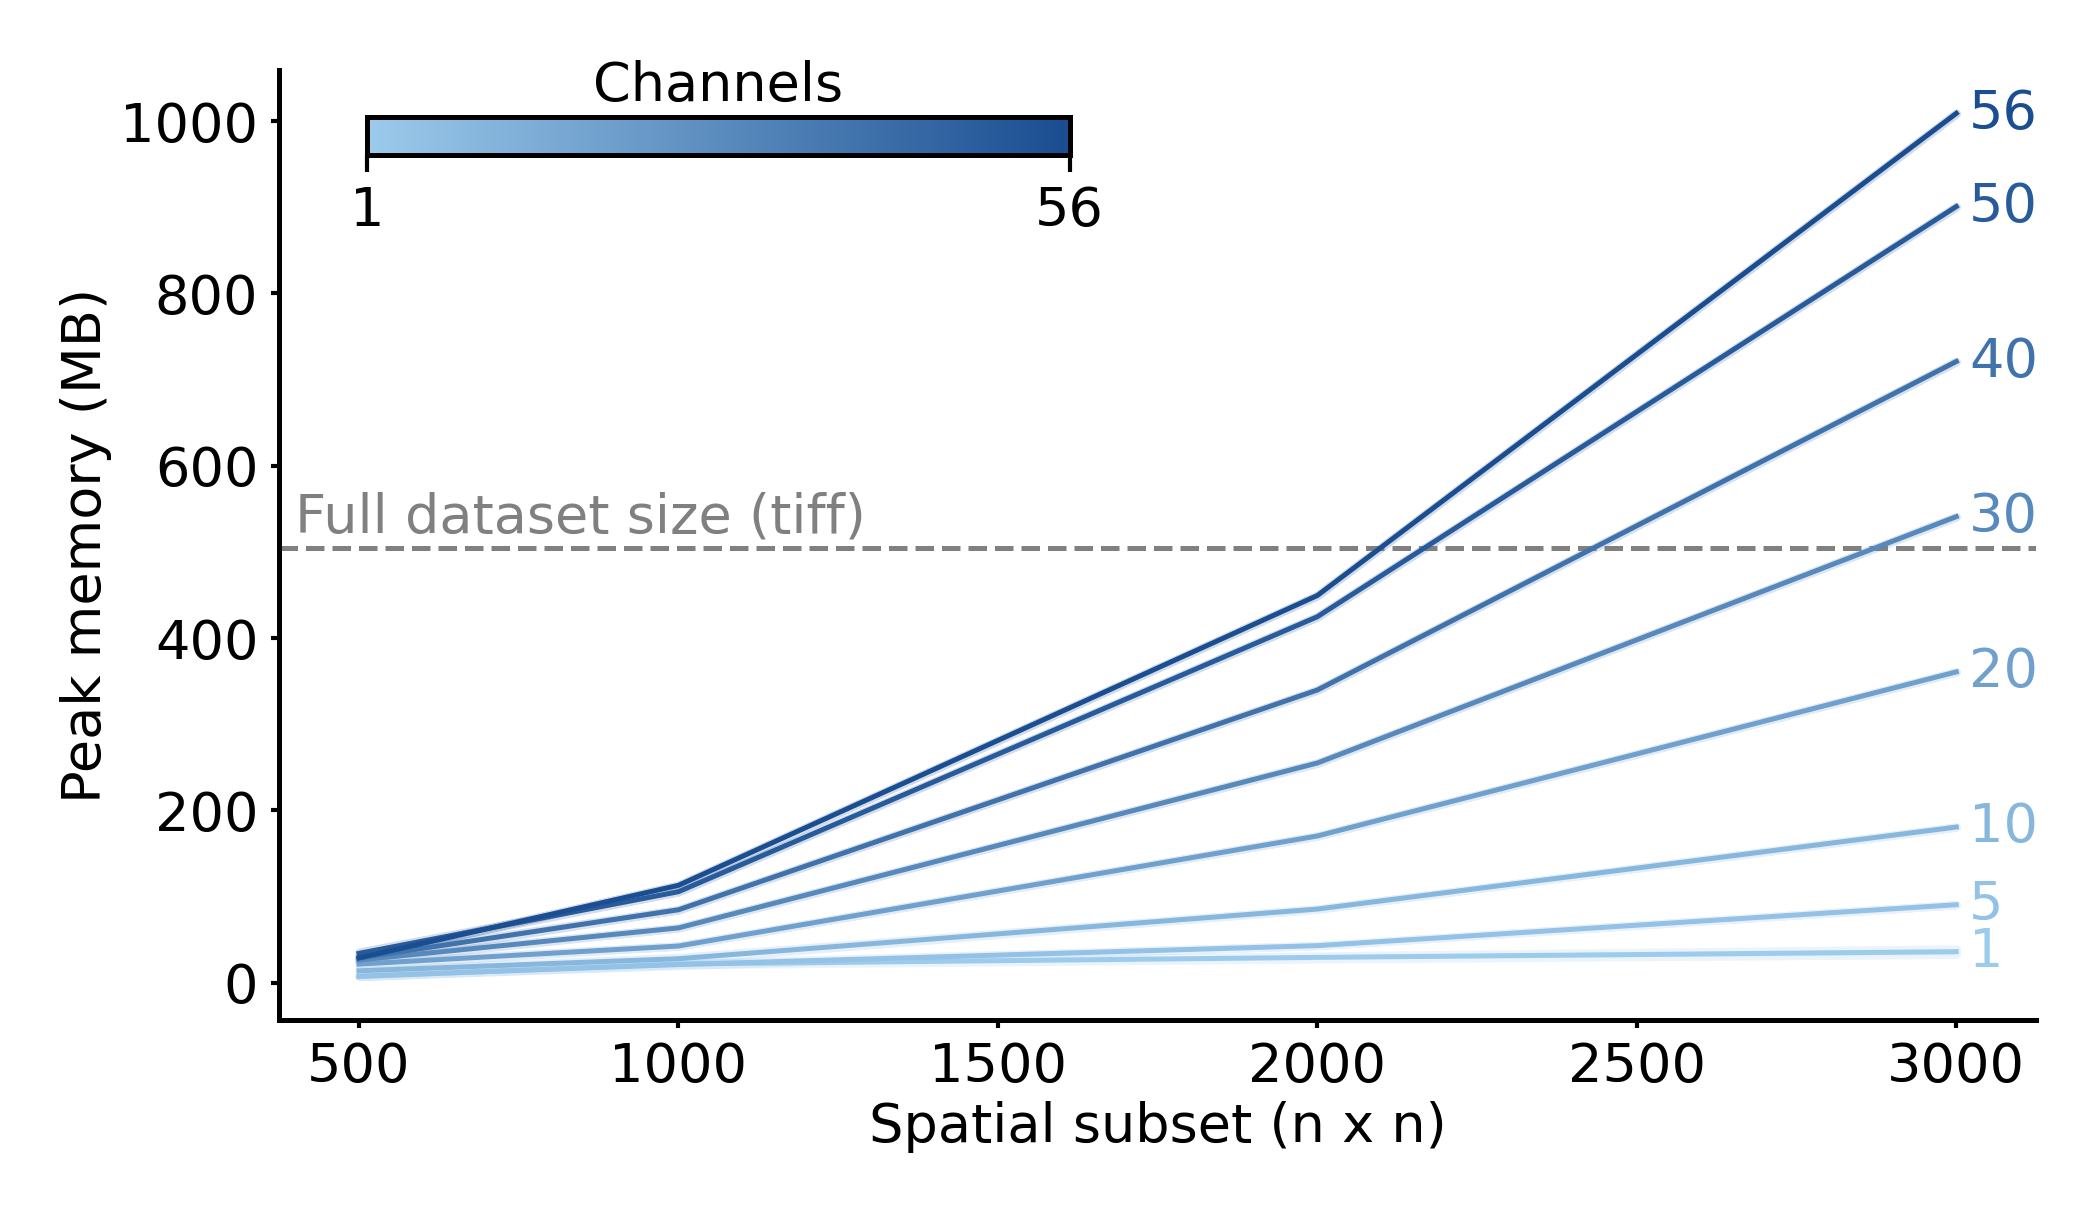

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import matplotlib as mpl

mpl.style.core.use('/g/huber/users/meyerben/notebooks/spatialproteomics_pipelines/spatialproteomics_bnhl/figures/pub_matplotlib_rc.ini')
font_size = 6.5
point_size = 20
point_border_color = '#49566d'  # dark gray
line_width = 0.6

# Set global font size
plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

# --- Global style ---
mpl.rcParams.update({
    "font.size": font_size,        # for labels, ticks, legends
    "axes.labelsize": font_size,   # axis labels
    "xtick.labelsize": font_size,  # x tick labels
    "ytick.labelsize": font_size,  # y tick labels
    "legend.fontsize": font_size,  # legend text
    "lines.linewidth": line_width, # default line width
    "axes.linewidth": line_width,  # axes border width
    "grid.linewidth": line_width   # grid lines
})

# --- Prep data ---
df_tmp = df[df['format'] == 'zarr_compute'].copy()
# df_tmp['subset'] = [x**2 for x in df_tmp['subset'].values]

# --- Make plot ---
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=600)

# --- Add baseline line + label ---
ax.axhline(tiffile_baseline, xmin=0, xmax=1, color='gray', linestyle='dashed')
ax.text(
    x=df_tmp['subset'].min() - 100,
    y=tiffile_baseline + 5,
    s="Full dataset size (tiff)",
    color="gray",
    ha="left", va="bottom",
    fontsize=font_size
)

# Define custom continuous colormap
bottom_color = "#9dcbec"
top_color = "#1a4e91"
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [bottom_color, top_color])
norm = mcolors.Normalize(vmin=df_tmp['channels'].min(), vmax=df_tmp['channels'].max())

# Use seaborn lineplot with custom palette (sample colormap for each channel)
unique_channels = np.sort(df_tmp['channels'].unique())
palette = {ch: cmap(norm(ch)) for ch in unique_channels}

sns.lineplot(
    data=df_tmp,
    x="subset",
    y="memory_mb",
    hue="channels",
    palette=palette,
    ax=ax,
    errorbar="sd",   # show standard deviation as shaded area
    linewidth=line_width
)

# --- Label channel lines at their last point ---
for channel in unique_channels:
    subdf = df_tmp[df_tmp["channels"] == channel]
    mean_vals = subdf.groupby("subset")["memory_mb"].mean().reset_index()
    last_row = mean_vals.sort_values("subset").iloc[-1]

    ax.text(
        x=last_row["subset"]+20,
        y=last_row["memory_mb"],
        s=str(channel),
        color=palette[channel],
        ha="left",
        va="center",
        fontsize=font_size
    )

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Add colorbar (horizontal, inside plot, top left but a bit lower) ---
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# inset axis inside plot
cax = inset_axes(
    ax,
    width="40%", height="4%",
    loc="upper left",
    bbox_to_anchor=(0.05, -0.05, 1, 1),  # ↓ lower it by reducing 0.95 → 0.88
    bbox_transform=ax.transAxes,
    borderpad=0
)

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=[1, 56])

# put label on top
cbar.set_label("Number of channels", fontsize=font_size, labelpad=2)
cbar.ax.xaxis.set_label_position("top")  # move label above

# ticks style
cbar.ax.tick_params(labelsize=font_size, length=2)

# --- Customize x-ticks ---
#custom_ticks = [0, 1000000, 4000000, 9000000]
#custom_labels = ["0", "1M", "4M", "Full"]

#ax.set_xticks(custom_ticks)
#ax.set_xticklabels(custom_labels)

# --- Style ---
sns.despine()
ax.set_xlabel("Spatial subset (n x n)")
ax.set_ylabel("Peak memory (MB)")
# ax.set_title("Memory consumption when subsetting TMA cores")
ax.get_legend().remove()

# --- After plotting, also update colorbar font and line width ---
cbar.ax.tick_params(labelsize=font_size)  # colorbar ticks
cbar.set_label("Channels", fontsize=font_size)

cbar.solids.set_edgecolor("face")   # remove white gaps in SVG
cbar.solids.set_rasterized(False)   # force vector output

plt.tight_layout()
plt.savefig('figs/supp_fig_7a.svg', bbox_inches='tight', pad_inches=0, format='svg')
plt.show()